In [16]:
import sys
sys.executable

'C:\\Users\\ADMIN\\myenv\\Scripts\\python.exe'

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

In [18]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=30

In [19]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
                                                    
)


Found 16011 files belonging to 10 classes.


In [20]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [21]:
len(dataset)


501

(32, 256, 256, 3)


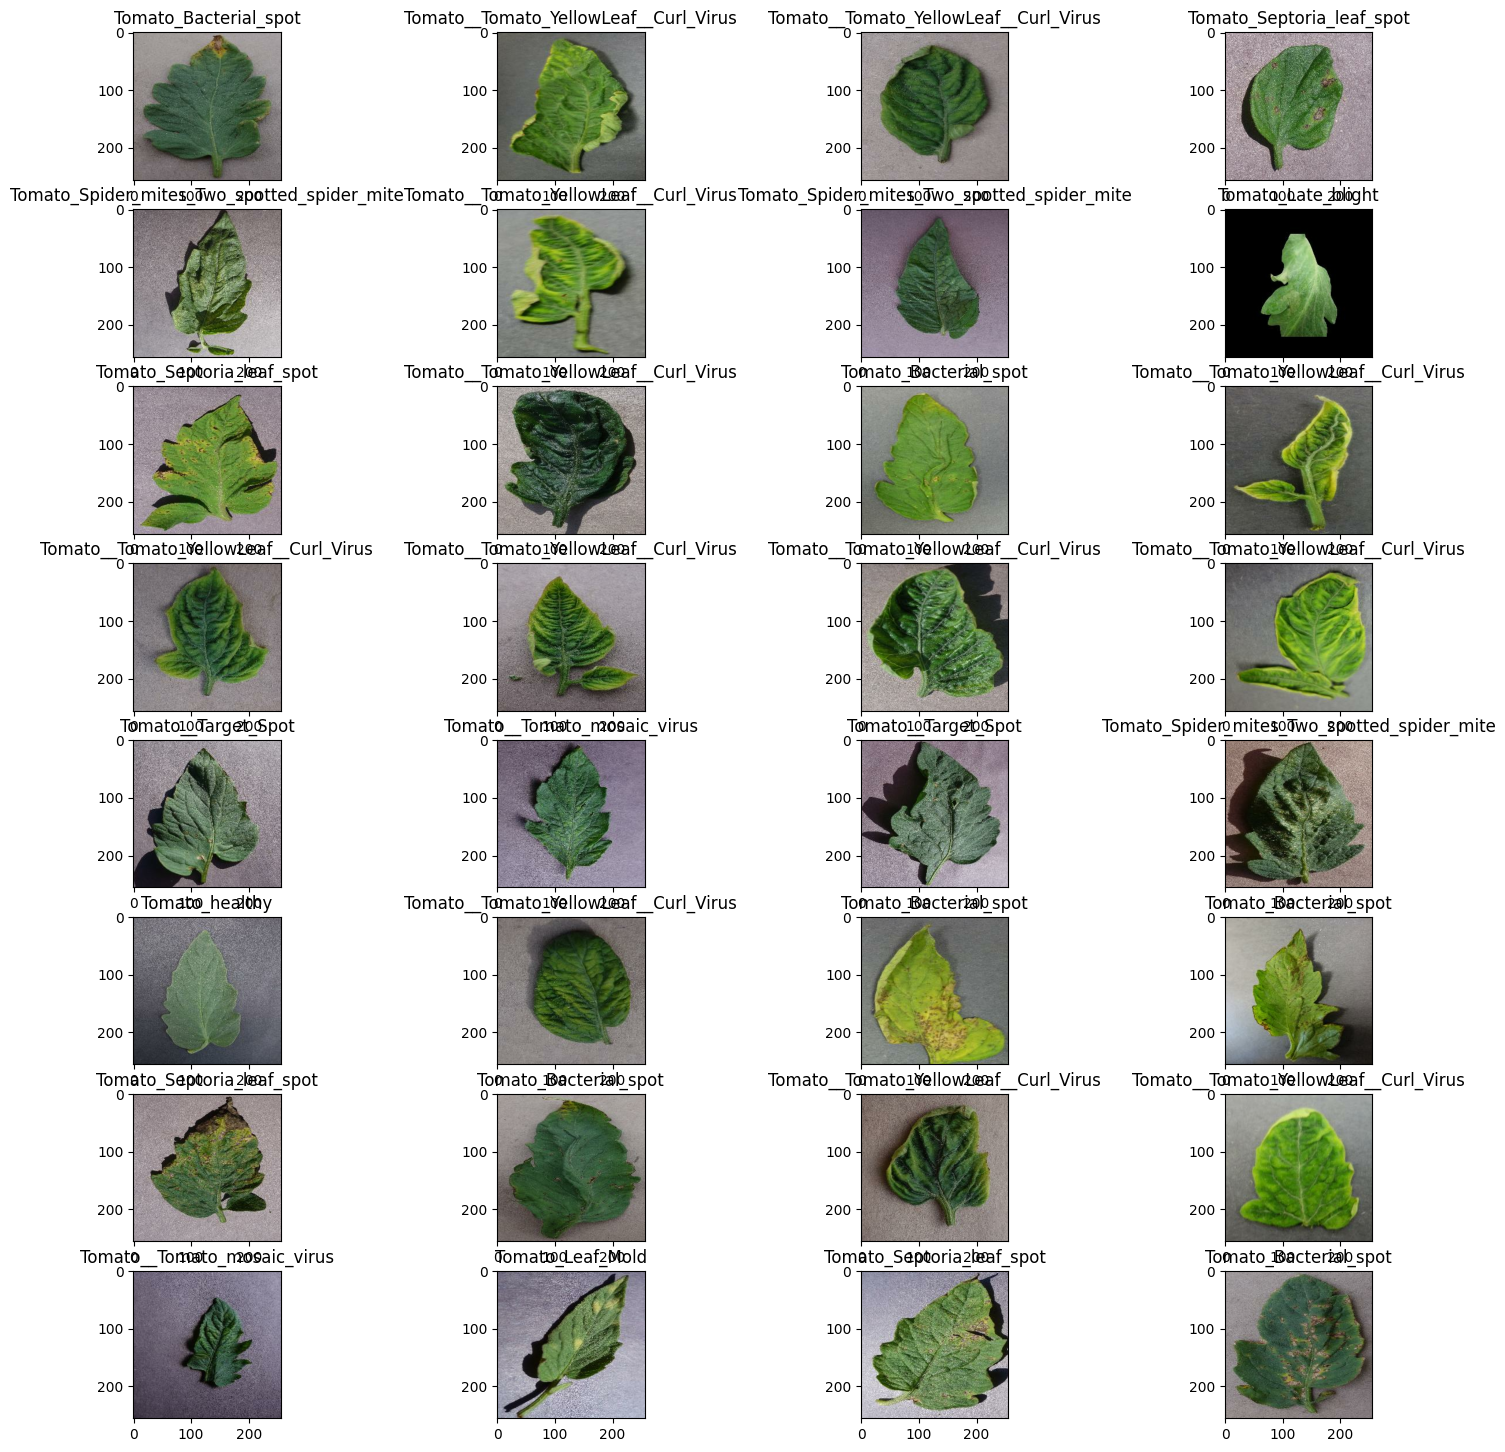

In [24]:
plt.figure(figsize=(18,18))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    for i in range (32):
        plt.subplot(8,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [25]:
train_size=0.8
len(dataset)*train_size

400.8

In [28]:
train_ds=dataset.take(401)  # <>out of 68 we took 54 for training.. 
len(train_ds)

401

In [29]:
test_ds=dataset.take(100)
len(test_ds)

100

In [30]:
val_size=0.1
len(dataset)*val_size

50.1

In [31]:
val_ds=test_ds.take(50)
len(val_ds)

50

In [32]:
test_ds=test_ds.skip(50)
len(test_ds)

50

In [33]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds) #501
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
     
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [34]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [35]:
print(len(train_ds),len(val_ds),len(test_ds))

400 50 51


In [46]:
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip,RandomRotation 


In [36]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
resize_and_rescale=tf.keras.Sequential([
    Resizing(IMAGE_SIZE,IMAGE_SIZE),
    Rescaling(1.0/255)
])

In [47]:
data_augmentation=tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2)
])

In [50]:
# n_classes=10 # early_blight,late_blight,healthy
# model=models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32,(3,3),activation='relu',input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)), # here 3 is channels RGB 
#     #             filters(Each filter learns to detect different features),kernelsize, activation func,input_image
#     #  higher the filters Start Small: Use a modest number of filters (e.g., 32 or 64) in the initial layers.
#     # start small with 32 or 64...Increase Filters in Deeper Layers: As the spatial dimensions of the feature maps decrease (due to pooling or strides), you can afford to increase the number of filters (e.g., 128, 256) to learn more complex patterns.
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(128,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(256,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(512,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(1024,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Flatten(),
#     layers.Dense(1024,activation='relu'),
#     layers.Dense(n_classes,activation='softmax')
#     # tf.keras.layers.Dense is a fully connected (or dense) layer
# ])

# model.build((BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))

In [78]:
import tensorflow as tf
from tensorflow.keras import layers, Model

n_classes = 10
IMAGE_SIZE=256
BATCH_SIZE = 32

# Input layer
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Initial Resizing and Rescaling
x = resize_and_rescale(inputs)  # Apply resizing and rescaling
x = data_augmentation(x)       # Apply data augmentation

# Initial Convolutional Layer
x = layers.Conv2D(64, (7, 7), strides=2, activation='relu', padding='same')(x)
x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

# First Residual Block
shortcut = x
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, shortcut])  # Residual connection
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x) 

# Second Residual Block
shortcut = layers.Conv2D(128, (1, 1), strides=2, padding='same')(x)  # Adjust dimensions for shortcut
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, shortcut])  # Residual connection
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x) 


# Third Residual Block
shortcut = layers.Conv2D(256, (1, 1), strides=2, padding='same')(x)  # Adjust dimensions for shortcut
x = layers.Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, shortcut])  # Residual connection
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x) 


# Fourth Residual Block
shortcut = layers.Conv2D(512, (1, 1), strides=2, padding='same')(x)  # Adjust dimensions for shortcut
x = layers.Conv2D(512, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, shortcut])  # Residual connection
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x) 


# Global Average Pooling and Fully Connected Layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) 
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x) 
outputs = layers.Dense(n_classes, activation='softmax')(x)

# Define the model
model = Model(inputs, outputs)

# Summary of the model

model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 256, 256, 3)       │               0 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_1 (Sequential)     │ (None, 256, 256, 3)       │               0 │ sequential[6][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_57 (Conv2D)            │ (None, 128, 128, 64)      │           9,472 │ sequential_1[6][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_11              │ (None, 64, 64, 64)        │               0 │ conv2d_57[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_58 (Conv2D)            │ (None, 64, 64, 64)        │          36,928 │ max_pooling2d_11[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_40        │ (None, 64, 64, 64)        │             256 │ conv2d_58[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_59 (Conv2D)            │ (None, 64, 64, 64)        │          36,928 │ batch_normalization_40[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_41        │ (None, 64, 64, 64)        │             256 │ conv2d_59[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_20 (Add)                  │ (None, 64, 64, 64)        │               0 │ batch_normalization_41[0]… │
│                               │                           │                 │ max_pooling2d_11[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_20 (ReLU)               │ (None, 64, 64, 64)        │               0 │ add_20[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 64, 64, 64)        │               0 │ re_lu_20[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_61 (Conv2D)            │ (None, 32, 32, 128)       │          73,856 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_42        │ (None, 32, 32, 128)       │             512 │ conv2d_61[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_62 (Conv2D)            │ (None, 32, 32, 128)       │         147,58

 Total params: 5,446,154 (20.78 MB)

 Trainable params: 5,442,314 (20.76 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [79]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [85]:
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=5,            # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best monitored metric
)


In [81]:
# from tensorflow.keras.applications import ResNet50V2

# backbone = ResNet50V2(
#     input_shape=(256, 256, 3),
#     include_top=False
# )

# model = tf.keras.Sequential([
#     backbone,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.summary()

In [86]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 0.001 * (0.1 ** (epoch // 10))  # Reduces LR every 10 epochs
)

In [87]:
history=model.fit(train_ds,
         epochs=20,
         batch_size=BATCH_SIZE,
         verbose=1,
         validation_data=val_ds,
         callbacks=[early_stopping,lr_scheduler]
        
)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 769s 2s/step - accuracy: 0.6688 - loss: 0.9716 - val_accuracy: 0.2581 - val_loss: 6.3414 - learning_rate: 0.0010
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 753s 2s/step - accuracy: 0.8016 - loss: 0.5787 - val_accuracy: 0.1956 - val_loss: 6.5688 - learning_rate: 0.0010
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 757s 2s/step - accuracy: 0.8496 - loss: 0.4432 - val_accuracy: 0.6413 - val_loss: 1.4378 - learning_rate: 0.0010
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 757s 2s/step - accuracy: 0.8835 - loss: 0.3384 - val_accuracy: 0.5181 - val_loss: 2.0804 - learning_rate: 0.0010
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.9001 - loss: 0.2904 - val_accuracy: 0.4156 - val_loss: 2.6371 - learning_rate: 0.0010
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 758s 2s/step - accuracy: 0.9137 - loss: 0.2649 - val_accuracy: 0.6756 - val_loss: 1.2424 - learning_rate: 0.0010
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 769s 2s/step - accuracy: 0.9226 - loss: 0.

In [88]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 400}

In [89]:
print(history.history.keys())
print(history.history['accuracy'])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
[0.7071093916893005, 0.8121874928474426, 0.8542187213897705, 0.8756250143051147, 0.9016406536102295, 0.9097656011581421, 0.9225000143051147, 0.9281250238418579, 0.9372656345367432, 0.9373437762260437, 0.9684374928474426, 0.9731249809265137, 0.9782812595367432, 0.9782031178474426, 0.9774218797683716, 0.9817187786102295, 0.9835156202316284]


In [90]:
scores=model.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 600ms/step - accuracy: 0.9792 - loss: 0.0654


In [91]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [92]:
print("Length of acc:", len(acc))
print("Length of val_acc:", len(val_acc))
print("EPOCHS:", EPOCHS)


Length of acc: 17
Length of val_acc: 17
EPOCHS: 30


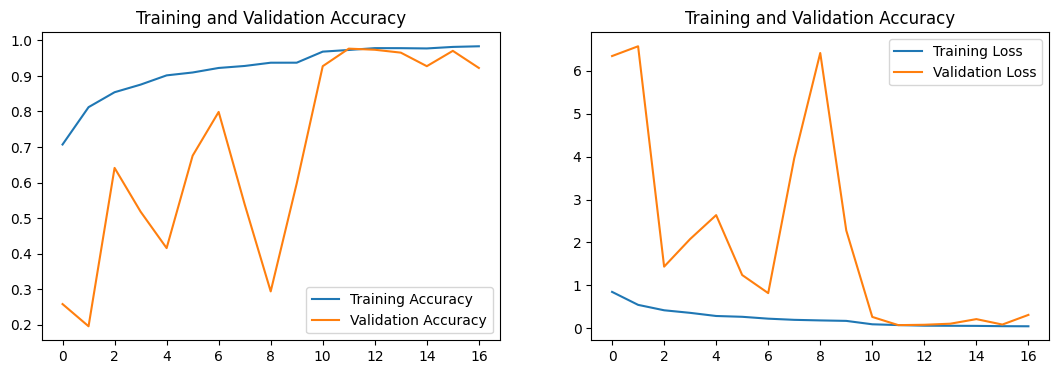

In [94]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.plot(range(17),acc,label='Training Accuracy')
plt.plot(range(17),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(17),loss,label='Training Loss')
plt.plot(range(17),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()


First image to predict
actual label: Tomato_Bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted lable: Tomato_Bacterial_spot


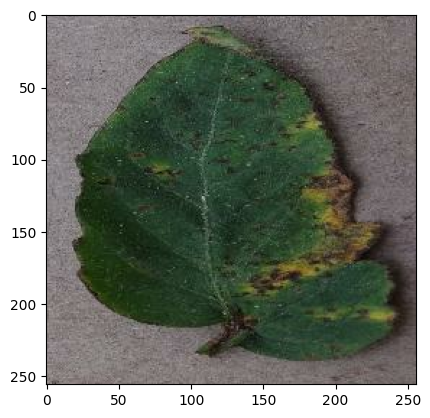

In [95]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction=model.predict(images_batch) # it contains prediction of the 32 images
#     print(batch_prediction[0])
#     print(np.argmax(batch_prediction[0]))
    print("Predicted lable:",class_names[np.argmax(batch_prediction[0])])

In [96]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) # creating a batch (1,256,256,3)
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
71.9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
99.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
99.96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
88.19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
96.8


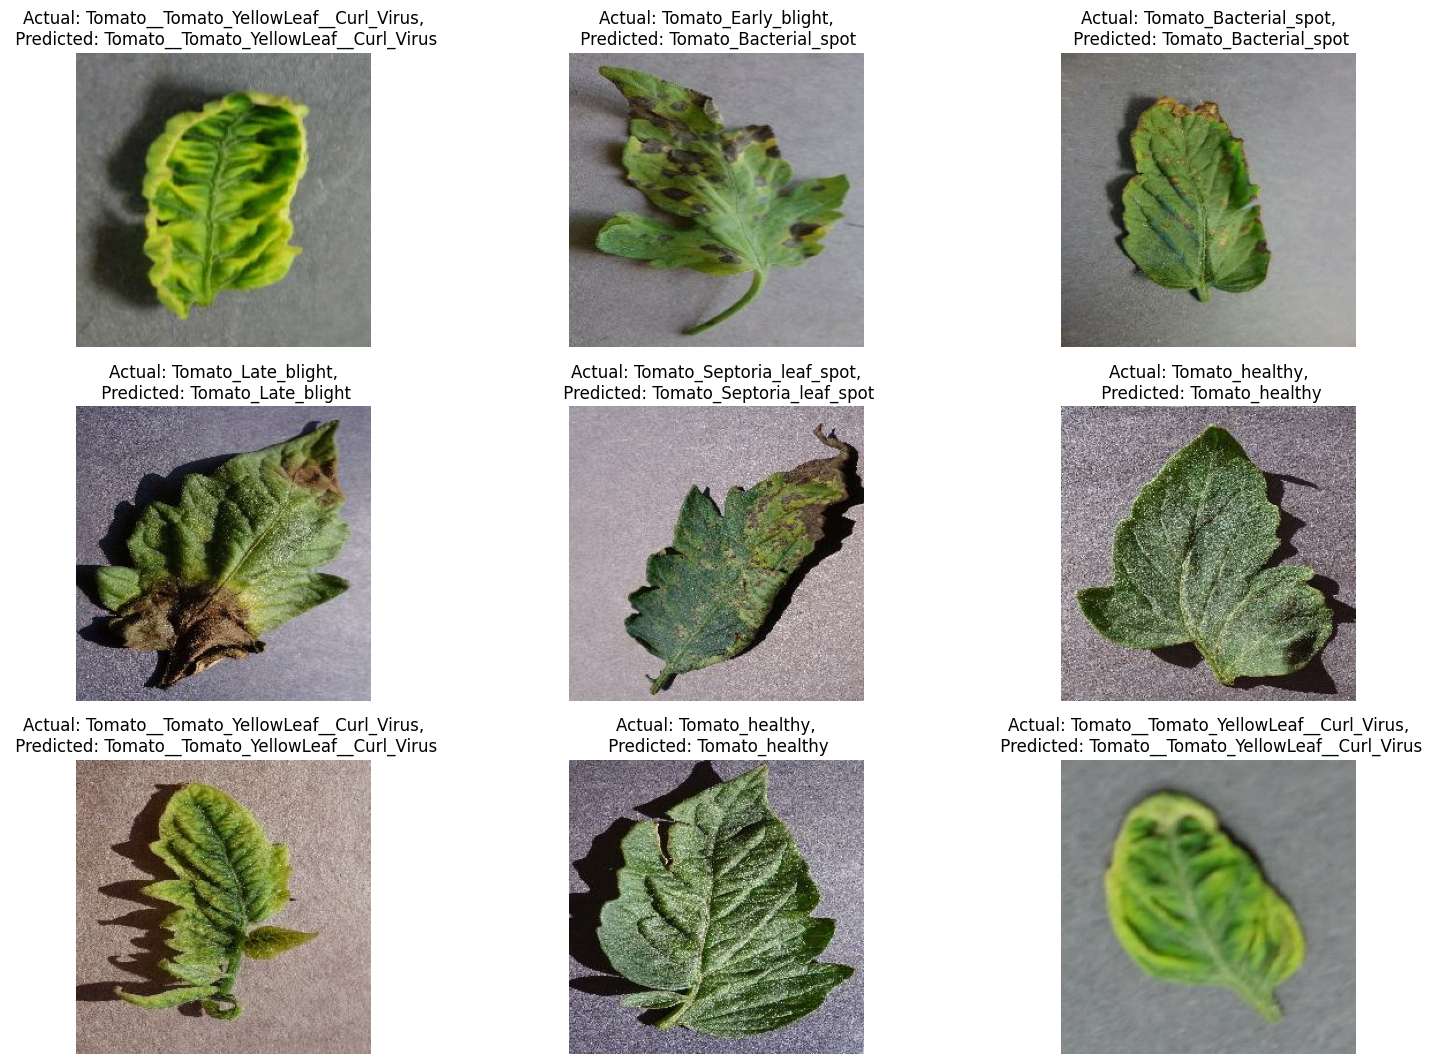

In [97]:
plt.figure(figsize=(18,13))

for images,labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}")
        print(confidence)
        plt.axis("off")
        